In [1]:
'''Trains a Siamese MLP on pairs of digits from the MNIST dataset.
It follows Hadsell-et-al.'06 [1] by computing the Euclidean distance on the
output of the shared network and by optimizing the contrastive loss (see paper
for more details).

# References
- Dimensionality Reduction by Learning an Invariant Mapping
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
Gets to 97.2% test accuracy after 20 epochs.
2 seconds per epoch on a Titan X Maxwell GPU

15/04/2020
Tensorflow 2 keras version
'''
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
#%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K

num_classes = 10

print("tf2=",tf.__version__)

tf2= 2.1.0


In [2]:
def rotate(img, angle):
    #img = cv2.imread(img)
    (height, width) = img.shape[:2]
    (cent_x, cent_y) = (width // 2, height // 2)

    mat = cv2.getRotationMatrix2D((cent_x, cent_y), -angle, 1.0)
    #cos = np.abs(mat[0, 0])
    #sin = np.abs(mat[0, 1])

    #n_width = int((height * sin) + (width * cos))
    #n_height = int((height * cos) + (width * sin))

    #mat[0, 2] += (n_width / 2) - cent_x
    #mat[1, 2] += (n_height / 2) - cent_y

    #return cv2.warpAffine(img, mat, (n_width, n_height))
    return cv2.warpAffine(img, mat,(height, width))

In [3]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1.0
    square_pred = K.square(y_pred)
    #square_pred = K.maximum(y_pred-margin, 0) #y_pred #K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0.0))
    tcost=y_true * square_pred
    fcost=(1.0 - y_true) * margin_square
    return K.mean(tcost + fcost)


In [22]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for m in range(1):
        for d in range(num_classes):
            for i in range(n):
                ridx=random.randrange(1,n)
                idx=(i+ridx)%n
                z1, z2 = digit_indices[d][i], digit_indices[d][idx]
                pairs += [[x[z1], x[z2]]]
                inc = random.randrange(1, num_classes)
                dn = (d + inc) % num_classes
                z1, z2 = digit_indices[d][i], digit_indices[dn][i]
                pairs += [[x[z1], x[z2]]]
                labels += [1.0, 0.0]
    return np.expand_dims(np.array(pairs).astype("float32"),axis=-1), np.array(labels).astype("float32")


In [5]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(input)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    #for 3D view
    x = Dense(  3)(x)
    return Model(input, x)


In [6]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))



In [7]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype("float32")
y_test  = y_test.astype("float32")
x_train /= 255
x_test /= 255
input_shape = (x_train.shape[1],x_train.shape[1],1)
#input_shape = x_train.shape[1:]

print(input_shape)

(28, 28, 1)


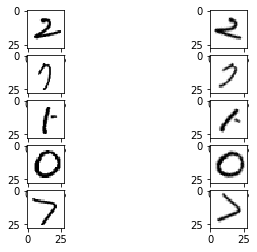

In [8]:
for i in range(5):
    plt.subplot(5,2,i*2+1)
    idx=random.randrange(0,x_train.shape[0])
    plt.imshow(x_train[idx], cmap="gray_r")
    #plt.show()
    imgr=rotate(x_train[idx],30)
    plt.subplot(5,2,i*2+2)
    plt.imshow(imgr,cmap="gray_r")
plt.show()

In [23]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

print("tr_pairs=",tr_pairs.shape,"tr_y=",tr_y.shape,tr_y.dtype)
print("te_pairs=",te_pairs.shape,"te_y=",te_y.shape,te_y.dtype)

tr_pairs= (108400, 2, 28, 28, 1) tr_y= (108400,) float32
te_pairs= (17820, 2, 28, 28, 1) te_y= (17820,) float32


In [17]:
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)


In [26]:
# train
epochs = 10
batch_size=1000
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))


Train on 108400 samples, validate on 17820 samples
Epoch 1/10
108400/108400 [==============================] - 18s 162us/sample - loss: 0.0053 - accuracy: 0.9966 - val_loss: 0.0157 - val_accuracy: 0.9840
Epoch 2/10
108400/108400 [==============================] - 17s 153us/sample - loss: 0.0018 - accuracy: 0.9988 - val_loss: 0.0136 - val_accuracy: 0.9858
Epoch 3/10
108400/108400 [==============================] - 17s 152us/sample - loss: 0.0011 - accuracy: 0.9992 - val_loss: 0.0157 - val_accuracy: 0.9829
Epoch 4/10
108400/108400 [==============================] - 17s 156us/sample - loss: 7.8476e-04 - accuracy: 0.9994 - val_loss: 0.0160 - val_accuracy: 0.9815
Epoch 5/10
108400/108400 [==============================] - 17s 155us/sample - loss: 4.5347e-04 - accuracy: 0.9997 - val_loss: 0.0158 - val_accuracy: 0.9847
Epoch 6/10
108400/108400 [==============================] - 17s 154us/sample - loss: 4.8091e-04 - accuracy: 0.9997 - val_loss: 0.0162 - val_accuracy: 0.9812
Epoch 7/10
108400/1

In [67]:
# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 99.98%
* Accuracy on test set: 97.14%


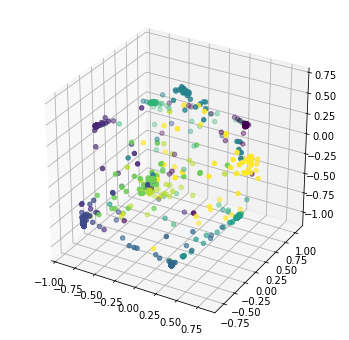

In [27]:
batch_size=128
encoder=base_network
# display a 3D plot of the digit classes in the latent space
ex_test=np.expand_dims(x_test,axis=-1)
x_test_encoded = encoder.predict(ex_test, batch_size=batch_size)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1],x_test_encoded[:, 2], c=y_test)
plt.show()